In [26]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import skew

In [27]:
# load dataset
inventory = pd.read_csv('T_F41SCHEDULE_B43.csv')

/var/folders/b7/s6xqpj4554qc6cr1r7n99rpr0000gn/T/ipykernel_31468/3205286260.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv('T_F41SCHEDULE_B43.csv')


#### Investigate the missing data in this dataset. Specifically, for each of the following variables that have missing data, decide if any imputation is possible. Give your reasoning and code if you decide to impute missing values.
- Columns for investigation: CARRIER, CARRIER_NAME, MANUFACTURE_YEAR, NUMBER_OF_SEATS, CAPACITY_IN_POUNDS, and AIRLINE_ID.
- For example, watch out for "North American Airlines" aircrafts. Are the CARRIER/UNIQUE_CARRIER column really missing?

In [28]:
# investigate missing values
inventory[['CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR', 
           'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID']].isna().sum()

CARRIER                49
CARRIER_NAME          105
MANUFACTURE_YEAR        3
NUMBER_OF_SEATS         7
CAPACITY_IN_POUNDS    101
AIRLINE_ID            105
dtype: int64

In [29]:
# impute CARRIER using UNIQUE_CARRIER
inventory['CARRIER'] = inventory['CARRIER'].fillna(inventory['UNIQUE_CARRIER'])

# find rows where CARRIER_NAME is missing but UNIQUE_CARRIER_NAME is present
uniques = inventory['CARRIER_NAME'].isna() & inventory['UNIQUE_CARRIER_NAME'].notna()
# impute CARRIER_NAME using UNIQUE_CARRIER_NAME 
inventory.loc[uniques, 'CARRIER_NAME'] = inventory.loc[uniques, 'UNIQUE_CARRIER_NAME']

# impute MANUFACTURE_YEAR using groupwise median
inventory['NUMBER_OF_SEATS'] = inventory.groupby('MODEL')['NUMBER_OF_SEATS'].transform(
    lambda x: x.fillna(x.median())
)

# impute CAPACITY_IN_POUNDS using groupwise median
inventory['CAPACITY_IN_POUNDS'] = inventory.groupby('MODEL')['CAPACITY_IN_POUNDS'].transform(
    lambda x: x.fillna(x.median())
)

I'm choosing not to impute AIRLINE_ID, as this is a unique identifier and imputing with an incorrect value could misrepresent an airline.

#### Inspect the columns MANUFACTURER, MODEL, AIRCRAFT_STATUS, and OPERATING_STATUS. Decide, for each column, if transformation or standardization of data are required. Give your reasoning and code if you decide to transform the data.

In [30]:
# standardize MANUFACTURER - convert to uppercase and remove whitespace
inventory['MANUFACTURER'] = inventory['MANUFACTURER'].astype(str).str.upper().str.strip()

# standardize MODEL - convert to uppercase and remove whitespace
inventory['MODEL'] = inventory['MODEL'].astype(str).str.upper().str.strip()

# standardize AIRCRAFT_STATUS - convert to uppercase and remove whitespace
inventory['AIRCRAFT_STATUS'] = inventory['AIRCRAFT_STATUS'].astype(str).str.upper().str.strip()

# standardize OPERATING_STATUS - convert to uppercase and remove whitespace
inventory['OPERATING_STATUS'] = inventory['OPERATING_STATUS'].astype(str).str.upper().str.strip()

#### Remove data rows that still have missing values. Report the amount of remaining data you obtained.

In [31]:
new_inventory = inventory.dropna()
print(f"Amount of remaining data: {len(new_inventory)}")

Amount of remaining data: 101275


#### Transformation and derivative variables
- For the columns NUMBER_OF_SEATS and CAPACITY_IN_POUNDS, check the skewness in the variable and plot a histogram for each variable.
- The Box-Cox transformation (scipy.stats.boxcox) is one possible way to transform variables into a "more-normal-like" variable. Apply the Box-Cox transformation for these two columns and save them as new columns, i.e. XXXXXXXXX_BOXCOX.
- Plot a histogram for each transformed variable.
- Describe what you observe before and after transformation.

In [32]:
# make sure both columns have strictly positive values (to prevent errors)
new_inventory = new_inventory[
    (new_inventory['NUMBER_OF_SEATS'] > 0) &
    (new_inventory['CAPACITY_IN_POUNDS'] > 0)
]

Skewness: NUMBER_OF_SEATS: 0.7795490789987679
Skewness: CAPACITY_IN_POUNDS: 4.182744658523329


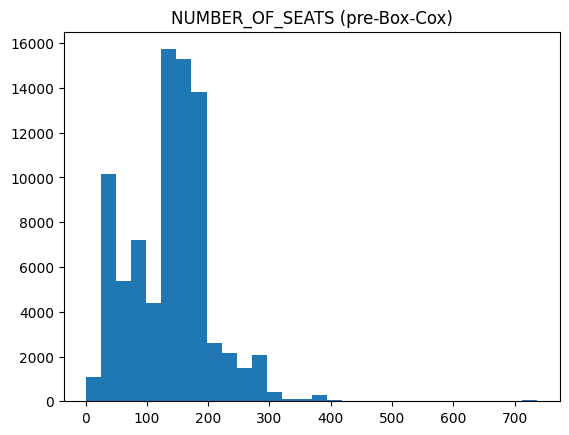

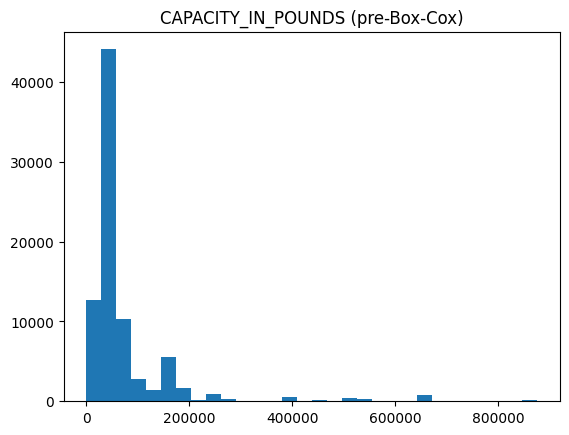

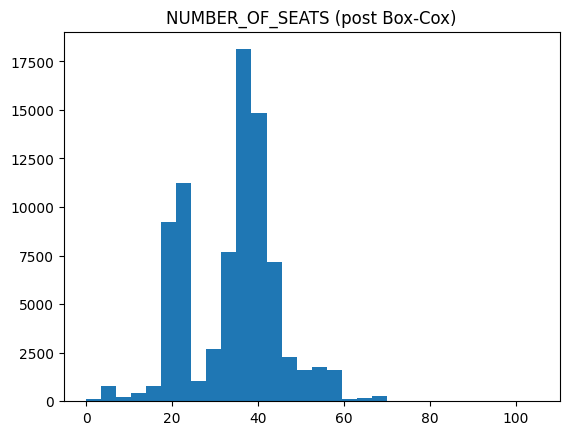

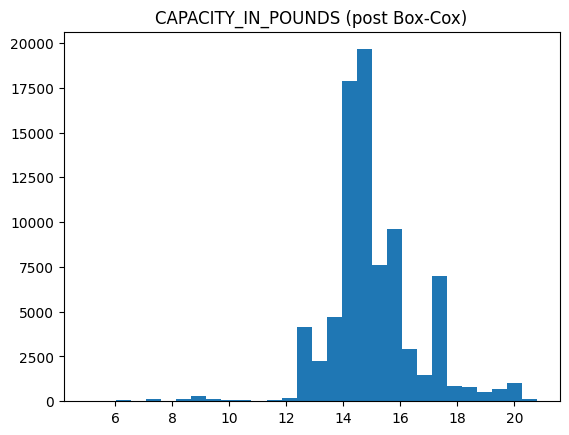

In [33]:
# check skewness:
print(f"Skewness: NUMBER_OF_SEATS: {skew(new_inventory['NUMBER_OF_SEATS'])}")
print(f"Skewness: CAPACITY_IN_POUNDS: {skew(new_inventory['CAPACITY_IN_POUNDS'])}")

# plot historgrams before box cox 
plt.hist(new_inventory['NUMBER_OF_SEATS'], bins=30)
plt.title('NUMBER_OF_SEATS (pre-Box-Cox)')
plt.show()

plt.hist(new_inventory['CAPACITY_IN_POUNDS'], bins=30)
plt.title('CAPACITY_IN_POUNDS (pre-Box-Cox)')
plt.show()

# apply box cox transformation
new_inventory['NUMBER_OF_SEATS_BOXCOX'], _ = boxcox(new_inventory['NUMBER_OF_SEATS'])
new_inventory['CAPACITY_IN_POUNDS_BOXCOX'], _ = boxcox(new_inventory['CAPACITY_IN_POUNDS'])

# plot histograms after box cox
plt.hist(new_inventory['NUMBER_OF_SEATS_BOXCOX'], bins=30)
plt.title('NUMBER_OF_SEATS (post Box-Cox)')
plt.show()

plt.hist(new_inventory['CAPACITY_IN_POUNDS_BOXCOX'], bins=30)
plt.title('CAPACITY_IN_POUNDS (post Box-Cox)')
plt.show()

##### Observations:
1. NUMBER_OF_SEATS:
- Before Box-Cox: right-skewed, with a high concentration of aircrafts with 50-200 seats
- After Box-Cox: more symmetric/bell-shaped distribution, suggesting that the transformation normalized the variable
2. CAPACITY_IN_POUNDS:
- Before Box-Cox: very right-skewed, with a high concentration of aircrafts under 100,000 pounds
- After Box-Cox: more centered distribution, demonstrating that the transformation normalized the variable and reduced skewness

#### Feature Engineering
1. Create a new column SIZE by the quartiles of NUMBER_OF_SEATS
- below 25% percentile: SMALL
- 25% - 50% percentile: MEDIUM
- 50% - 75% percentile: LARGE
- above 75% percentile: XLARGE
2. For each size group, provide and plot the proportions of aircrafts that are operating versus not (OPERATING_STATUS).
3. For each size group, provide and plot the proportions of aircrafts belonging to each aircraft status group (AIRCRAFT_STATUS).
4. Provide a written summary of your findings.

In [34]:
# set quantiles
quantile1 = new_inventory['NUMBER_OF_SEATS'].quantile(0.25)
quantile2 = new_inventory['NUMBER_OF_SEATS'].quantile(0.50)
quantile3 = new_inventory['NUMBER_OF_SEATS'].quantile(0.75)

# Define size bins
def size_label(seats):
    if seats < quantile1:
        return 'SMALL'
    elif seats < quantile2:
        return 'MEDIUM'
    elif seats < quantile3:
        return 'LARGE'
    else:
        return 'XLARGE'

new_inventory['SIZE'] = new_inventory['NUMBER_OF_SEATS'].apply(size_label)
new_inventory['SIZE'].value_counts()

SIZE
LARGE     24138
XLARGE    21235
MEDIUM    20335
SMALL     16594
Name: count, dtype: int64

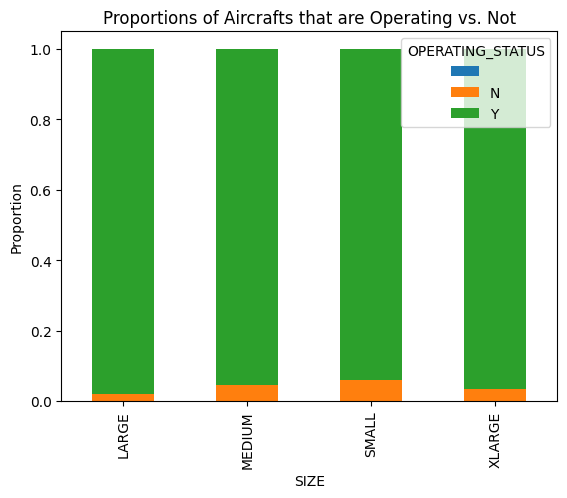

In [35]:
# plot the proportions of aircrafts that are operating versus not (OPERATING_STATUS)

# group by size
opstat_groups = new_inventory.groupby(['SIZE', 'OPERATING_STATUS']).size().unstack().fillna(0)
# calculate proportins
opstat_proportions = opstat_groups.div(opstat_groups.sum(axis=1), axis=0)
# plot proportions
opstat_proportions.plot(kind='bar', stacked=True)
plt.title('Proportions of Aircrafts that are Operating vs. Not')
plt.ylabel('Proportion')
plt.show()

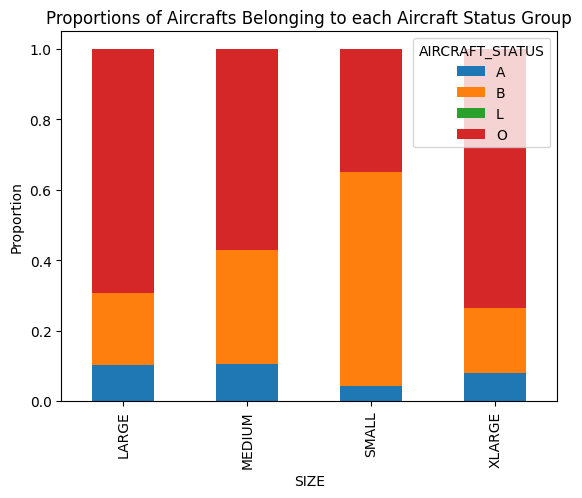

In [36]:
# plot the proportions of aircrafts belonging to each aircraft status group (AIRCRAFT_STATUS)
astat_groups = new_inventory.groupby(['SIZE', 'AIRCRAFT_STATUS']).size().unstack().fillna(0)
astat_proportions = astat_groups.div(astat_groups.sum(axis=1), axis=0)
astat_proportions.plot(kind='bar', stacked=True)
plt.title('Proportions of Aircrafts Belonging to each Aircraft Status Group')
plt.ylabel('Proportion')
plt.show()

##### Summary of Findings
1. Operating Status by Size:
- the vast majority of aircrafts are actively operating for each size group
- small and medium-sized aircrafts have slightly higher proportions of non-operating aircrafts compared to larger aircrafts
2. Aircraft Status by Size:
- Smaller aircrafts have higher proportions of status B
- Larger aircrafts have higher proportions of status O